# Predictive Model for Customer Churn

**Annotation:**

The project **aims** to develop a prediction model for predicting customer churn. The following steps will be taken to achieve this:

1. Data Pre-processing
2. Exploratory Analysis
3. Data Preparation for Machine Learning
4. Model Selection and Training Algorithm
5. Training, Testing, and Model Evaluation

Aligned with the client’s business objectives, the project entails creating a binary classification model to help the telecom provider prevent customer churn.

**Data Source:**

The dataset consists of multiple files obtained from different sources:

1. Data detailing contract terms.
2. Data pertaining to client personal information.
3. Data concerning Internet services.
4. Data outlining telephony services.

The contract information is accurate as of February 1, 2020.

# Прогнозная модель для предсказания оттока клиентов

**Аннотация проекта** 

На данных компании оператора связи проводится исследовательский анализ с последующей разработкой решения на основе моделирования, которое позволит персонализировать пользовательские предложения для предупреждения отказа клиентов от услуг связи.


**Цель исследования** — разработать модель, которая предскажет вероятность прекращения клиентом абонентского договора. Для этого будут выполнены следующие шаги:
- Загрузка данных и предварительная оценка.
- Исследовательский анализ и предобработка данных.
- Подготовка данных для машинного обучения.
- Выбор модели и алгоритма её обучения.
- Обучение, настройка, тестирование и проверка качества моделей. 
- Прогноз и выводы.
- Итоговый отчёт.  

Учитывая бизнес-задачи заказчика, предстоит решить задачу бинарной классификации. В частности, разработать прогнозную модель и обучить её классифицировать клиентов по критерию откажется / не откажется пользователь от услуг связи.

**Описание данных**

Данные состоят из нескольких файлов, полученных из разных источников:
1. Данные с информацией об условиях договора.
2. Данные с информацией о персональных данных клиента.
3. Данные с информацией об интернет-услугах.
4. Данные с информацией об услугах телефонии.

Информация о договорах актуальна на 1 февраля 2020 года.

In [1]:
! pip install --upgrade scikit-learn -q


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
! pip install phik -q


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
! pip install shap -q


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
! pip install --upgrade shap -q


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
# импорт библиотек, модулей и функций
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import re, time
import warnings

# функция для расчёта матрицы корреляции
from phik import phik_matrix

# инструменты для пайплайна и преобразования данных
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# функции для разделения датасета на выборки и автоподбора гиперпараметров
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# классы для моделей машинного обучения
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
import xgboost as xgb

# инструменты для расчёта метрик
from sklearn.metrics import (
    roc_auc_score, 
    confusion_matrix,
    classification_report,
    accuracy_score, 
    precision_score, 
    recall_score
)

In [6]:
# установим настройки для отображения всех столбцов датафрейма
pd.set_option('display.max_columns', None)

### Загрузка данных

1. Загрузим файлы и проверим, что данные в таблицах соответствуют описанию.
2. Данные представлены в четырёх файлах. Определим функцию, чтобы нивелировать повторяющиеся действия при проверке данных на дубликаты и пустые значения.

In [7]:
# определим функцию data_isnull_isdup() для проверки на дубликаты и пустые значения
def data_isnull_isdup(data):
    print('Количество явных дубликатов:', data.duplicated().sum())
    print('Количество пропусков:')
    print(data.isnull().sum())

In [8]:
# считываем данные из csv-файлов и сохраняем в соответствующие датафреймы
try:
    df_contract = pd.read_csv('/datasets/contract_new.csv', parse_dates=['BeginDate', 'EndDate'])
    df_personal = pd.read_csv('/datasets/personal_new.csv')
    df_internet = pd.read_csv('/datasets/internet_new.csv')
    df_phone = pd.read_csv('/datasets/phone_new.csv')
except:
    df_contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv', parse_dates=['BeginDate', 'EndDate'])
    df_personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
    df_internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
    df_phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')

In [9]:
# выведем первые строки по каждой таблице
display(df_contract.head())
display(df_personal.head())
display(df_internet.head())
display(df_phone.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


**Вывод:**
- Данные корректно загружены.
- Названия колонок не соответствуют единому стилю.
- Во всех файлах столбец `customerID` содержит код клиента, его будем использовать при создании финального датасета.

In [10]:
# рассмотрим основную информацию по четырём датасетам
print('\n\n-------------------------Первый Датасет---------------------------------\n\n')
display(df_contract.info())
display(df_contract.describe())
print('\n\n-------------------------Второй Датасет---------------------------------\n\n')
display(df_personal.info())
display(df_personal.describe())
print('\n\n-------------------------Третий Датасет---------------------------------\n\n')
display(df_internet.info())
display(df_internet.describe())
print('\n\n-------------------------Четвёртый Датасет-------------------------------\n\n')
display(df_phone.info())
display(df_phone.describe())



-------------------------Первый Датасет---------------------------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


None

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000




-------------------------Второй Датасет---------------------------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000




-------------------------Третий Датасет---------------------------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,0810-BDHAW,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785




-------------------------Четвёртый Датасет-------------------------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,7593-XFKDI,No
freq,1,3390


**Вывод:**

Основываясь на предварительном обзоре датафреймов отметим следующее:
- Названия колонок следует привести к единому стилю.
- Таблицы содержат столбцы со значениями различного типа: числовые, категориальные, а также признаки формата дата.
- Количество значений в столбцах внутри каждого датафрейма не различается. При этом, третий и четвёртый датафреймы содержат меньше значений по сравнению с первым и вторым. По-видимому, это связано с типом получаемых услуг, в частности, некоторые клиенты пользуются только интернет-услугами, и есть клиенты, которые пользуются только услугами телефонии. Учтём эти особенности при объединении датафреймов.
- Очевидно, не все признаки будут информативны для обучения модели классификации, однако пока оставим как есть и оценим их вклад по результатам.
- Целевой признак должен представлять отток клиентов — да (1) или нет (0). Следовательно, на основе `EndDate` создадим столбец со значениями целевого признака, который будет представлен бинарной категорией — прекращение договора «да» или «нет».
- Кроме того, для корректного обучения модели считаем полезным создать новый признак, который будет представлять длительность действия контракта в днях. Это поможет избежать утечки данных и позволит модели выучить соответствующие закономерности для более точного прогноза. Для создания нового признака используем столбцы `BeginDate` и `EndDate`, которые после удалим.
- Числовые значения в столбце `TotalCharges` и значения даты в столбце `EndDate` представлены форматом object, что не является корректным. Исследуем эти столбцы подробней на этапе предобработки.

### Предобработка данных

1. Проверим датасеты на наличие пропусков и дубликатов. 
2. Рассмотрим корректность типов данных. При необходимости устраним проблемы.

**1. Данные с информацией о договоре**

In [11]:
# приведём названия столбцов к единому стилю
df_contract.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower()for i in df_contract.columns]
df_contract.columns

Index(['customer_i_d', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

In [12]:
# вызовем функцию data_isnull_isdup() и оценим есть ли пропуски и дубликаты 
data_isnull_isdup(df_contract)

Количество явных дубликатов: 0
Количество пропусков:
customer_i_d         0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
dtype: int64


In [13]:
# рассмотрим значения в total_charges
df_contract['total_charges'].unique()

array(['31.04', '2071.84', '226.17', ..., '325.6', '520.8', '7251.82'],
      dtype=object)

In [14]:
# рассмотрим описание значений по столбцу
df_contract['total_charges'].describe()

count     7043
unique    6658
top           
freq        11
Name: total_charges, dtype: object

In [15]:
# рассмотрим значения в end_date
df_contract['end_date'].unique()

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

In [16]:
# рассмотрим описание значений по столбцу
df_contract['end_date'].describe()

count     7043
unique      67
top         No
freq      5942
Name: end_date, dtype: object

**Вывод:**
- В столбце `total_charges` обнаружены неявные пустые значения в 11 строках датафрейма. Так как их количество малочисленно, избавимся от этих строк для корректного изменения типа данных с `object` на `float`.
- В столбце `end_date` наряду с датами окончания контрактов обнаружены строковые значения `No`. Вероятно, это означает, что у контракта нет даты окончания или он действует. Используем этот столбец для создания целевого признака, а затем заменим `No` на актуальную дату выгрузки данных, чтобы преобразовать значения в тип datetime и создать новый признак с продолжительностью контракта (в днях).

In [17]:
# удаление пустых строк в total_charges
df_contract = df_contract[df_contract['total_charges'].str.strip() != '']
# сброс индекса после удаления
df_contract.reset_index(drop=True, inplace=True)

# преобразование значений столбца total_charges в тип данных float
df_contract['total_charges'] = df_contract['total_charges'].astype(float)

In [18]:
# создание столбца с целевым признаком отток
df_contract['churn'] = (df_contract['end_date'] != 'No').astype(int)
df_contract['churn'].unique()

array([0, 1])

In [19]:
# преобразование столбца end_date
df_contract['end_date'] = df_contract['end_date'].where(df_contract['end_date'] != 'No', '2020-02-01')
df_contract['end_date'] = pd.to_datetime(df_contract['end_date'])

In [20]:
# создадим новый признак с продолжительностью контракта (в днях)
df_contract['duration'] = (df_contract['end_date'] - df_contract['begin_date']).dt.days

In [21]:
# удалим столбцы с датами, чтобы предупредить утечку данных при обучении модели
df_contract = df_contract.drop(['begin_date', 'end_date'], axis=1)

**2. Данные с информацией о персональных данных клиента**

In [22]:
# приведём названия столбцов к единому стилю
df_personal.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower()for i in df_personal.columns]
df_personal.columns

Index(['customer_i_d', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

In [23]:
# вызовем функцию data_isnull_isdup() и оценим есть ли пропуски и дубликаты 
data_isnull_isdup(df_personal)

Количество явных дубликатов: 0
Количество пропусков:
customer_i_d      0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64


**3. Данные с информацией об интернет-услугах**

In [24]:
# приведём названия столбцов к единому стилю
df_internet.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower()for i in df_internet.columns]
df_internet.columns

Index(['customer_i_d', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_t_v',
       'streaming_movies'],
      dtype='object')

In [25]:
# вызовем функцию data_isnull_isdup() и оценим есть ли пропуски и дубликаты 
data_isnull_isdup(df_internet)

Количество явных дубликатов: 0
Количество пропусков:
customer_i_d         0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_t_v        0
streaming_movies     0
dtype: int64


In [26]:
# рассмотрим значения в internet_service
df_internet['internet_service'].unique()

array(['DSL', 'Fiber optic'], dtype=object)

**4. Данные с информацией об услугах телефонии**

In [27]:
# приведём названия столбцов к единому стилю
df_phone.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower()for i in df_phone.columns]
df_phone.columns

Index(['customer_i_d', 'multiple_lines'], dtype='object')

In [28]:
# вызовем функцию data_isnull_isdup() и оценим есть ли пропуски и дубликаты 
data_isnull_isdup(df_phone)

Количество явных дубликатов: 0
Количество пропусков:
customer_i_d      0
multiple_lines    0
dtype: int64


**Вывод:**
- Датасеты предобработаны: названия столбцов приведены к единому стилю, устранены неявные пропуски, преобразованы типы данных.
- Созданы новые признаки для корректного обучения модели.
- Удалены столбцы, которые могут стать причиной утечки данных при обучении модели.

### Объединение таблиц

In [29]:
# сформируем единый датасет для дальнейшего исследовательского анализа
df = (df_contract
        .merge(df_internet, on=['customer_i_d'], how='left')
        .merge(df_personal, on=['customer_i_d'], how='left')
        .merge(df_phone, on=['customer_i_d'], how='left')
       )

In [30]:
# проверим результат объединения
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_i_d       7032 non-null   object 
 1   type               7032 non-null   object 
 2   paperless_billing  7032 non-null   object 
 3   payment_method     7032 non-null   object 
 4   monthly_charges    7032 non-null   float64
 5   total_charges      7032 non-null   float64
 6   churn              7032 non-null   int32  
 7   duration           7032 non-null   int64  
 8   internet_service   5512 non-null   object 
 9   online_security    5512 non-null   object 
 10  online_backup      5512 non-null   object 
 11  device_protection  5512 non-null   object 
 12  tech_support       5512 non-null   object 
 13  streaming_t_v      5512 non-null   object 
 14  streaming_movies   5512 non-null   object 
 15  gender             7032 non-null   object 
 16  senior_citizen     7032 

**Вывод:**
- После объединения датасетов появились пропуски, так как таблицы различаются по количеству значений.
- Заполним пропуски значением `No`, исходя из логики того, что пропуск образован там, где клиент не пользуется данной услугой.
- Для удобства дальнейшего анализа и улучшения производительности моделей преобразуем категориальные переменные `Yes`/`No` в двоичную форму `1`/`0`.

In [31]:
# заполним пропущенные значения
df = df.fillna('No')

In [32]:
# реобразуем категориальные переменные Yes/No в двоичную форму 1/0
cols_to_convert = [
    'paperless_billing', 'partner', 'dependents', 'online_security',
    'online_backup', 'device_protection', 'tech_support', 'streaming_t_v',
    'streaming_movies', 'multiple_lines'
]

for col in cols_to_convert:
    df[col] = (df[col] == 'Yes').astype('int64')

In [33]:
# проверим результат объединения
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_i_d       7032 non-null   object 
 1   type               7032 non-null   object 
 2   paperless_billing  7032 non-null   int64  
 3   payment_method     7032 non-null   object 
 4   monthly_charges    7032 non-null   float64
 5   total_charges      7032 non-null   float64
 6   churn              7032 non-null   int32  
 7   duration           7032 non-null   int64  
 8   internet_service   7032 non-null   object 
 9   online_security    7032 non-null   int64  
 10  online_backup      7032 non-null   int64  
 11  device_protection  7032 non-null   int64  
 12  tech_support       7032 non-null   int64  
 13  streaming_t_v      7032 non-null   int64  
 14  streaming_movies   7032 non-null   int64  
 15  gender             7032 non-null   object 
 16  senior_citizen     7032 

**Вывод:**
- Сформирован единый датасет, который послужит основой для обучения и тестирования модели.
- Объёма данных достаточно для дальнейшего исследовательского анализа.

### Исследовательский анализ данных

- Проведём исследовательский анализ признаков.
- Оценим особенности распределения данных для выбора корректных способов подготовки к обучению модели.

**1. Анализ категориальных признаков**

In [34]:
# рассмотрим описательные статистики по категориальным столбцам
df.describe(include='object')

,customer_i_d,type,payment_method,internet_service,gender
count,7032,7032,7032,7032,7032
unique,7032,3,4,3,2
top,7593-XFKDI,Month-to-month,Electronic check,Fiber optic,Male
freq,1,3875,2365,3096,3549


In [35]:
# рассмотрим уникальные значения в столбцах с категориальными признаками
cat_var = df.select_dtypes(exclude='number').columns.tolist()

for col in cat_var:
    unique_values = df[col].unique()
    print(f"Уникальные значения для {col}: {unique_values}")

Уникальные значения для customer_i_d: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Уникальные значения для type: ['Month-to-month' 'One year' 'Two year']
Уникальные значения для payment_method: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Уникальные значения для internet_service: ['DSL' 'Fiber optic' 'No']
Уникальные значения для gender: ['Female' 'Male']


**Вывод:**
- В таблице четыре признака, не включая customer_i_d, которые содержат от двух до четырёх категорий.
- Значения соответствуют представленным категориям признаков.

**2. Анализ количественных признаков**

In [36]:
# рассмотрим описательные статистики по количественным признакам
num_var = ['monthly_charges', 'total_charges', 'duration']
df[num_var].describe().T

,count,mean,std,min,25%,50%,75%,max
monthly_charges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
total_charges,7032.0,2118.621822,2112.736199,19.05,439.7450,1345.275,3239.3175,9221.38
duration,7032.0,899.961320,682.738777,28.00,276.0000,761.000,1461.0000,2314.00


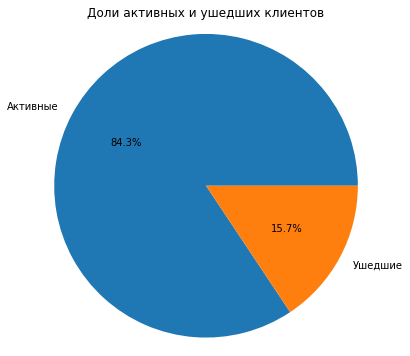

In [37]:
# визуализируем целевой признак и оценим доли активных и ушедших клиентов
churn_counts = df['churn'].value_counts()
# построим круговую диаграмму
plt.figure(figsize=(6, 6))
plt.pie(churn_counts, labels=['Активные', 'Ушедшие'], autopct='%1.1f%%')
plt.title('Доли активных и ушедших клиентов')
plt.axis('equal')
plt.show()

**Вывод:**
- В данных очевиден дисбаланс классов, учтём это при выборе алгоритмов обучения модели и метрик оценки качества. 
- Выполним стратификацию по целевому признаку в пайплайне.

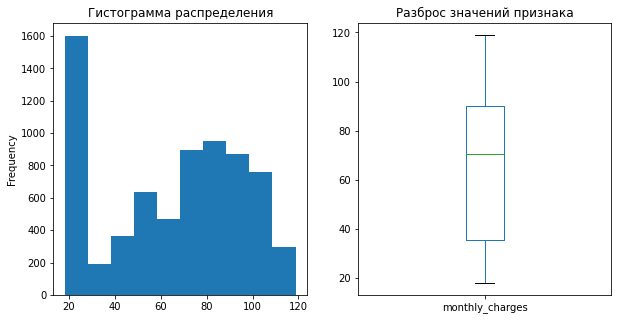

In [38]:
# рассмотрим распределение значений по расходам за месяц
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
df['monthly_charges'].plot(kind='hist', bins=10, ax=axes[0])
axes[0].set_title('Гистограмма распределения')
df['monthly_charges'].plot(kind='box', ax=axes[1])
axes[1].set_title('Разброс значений признака')
plt.show()

**Вывод:**
- Расходы клиентов за месяц в среднем представляют значение около 70.
- Выбросов, которые указывали бы на экстремально низкие или высокие значения, не обнаружено.

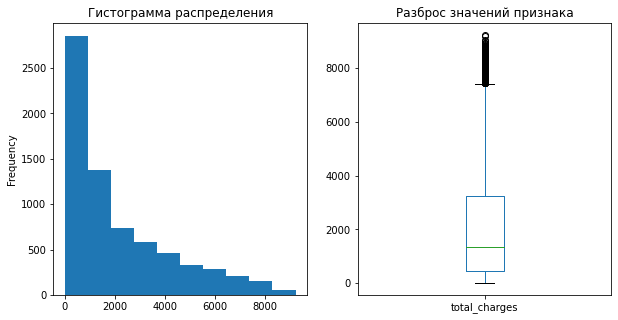

In [39]:
# рассмотрим распределение значений по общим расходам абонента
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
df['total_charges'].plot(kind='hist', bins=10, ax=axes[0])
axes[0].set_title('Гистограмма распределения')
df['total_charges'].plot(kind='box', ax=axes[1])
axes[1].set_title('Разброс значений признака')
plt.show()

**Вывод:**
- Гистограмма скошена вправо, распределение имеет положительную асимметрию.
- В среднем общие расходы абонентов представлены значением около 1400.
- Выбросы указывают, что есть абоненты с необычно высокими общими расходами по сравнению с остальной частью набора данных.

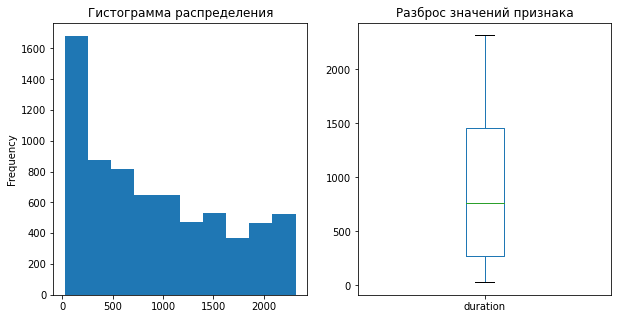

In [40]:
# рассмотрим распределение значений по продолжительности контракта (в днях)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
df['duration'].plot(kind='hist', bins=10, ax=axes[0])
axes[0].set_title('Гистограмма распределения')
df['duration'].plot(kind='box', ax=axes[1])
axes[1].set_title('Разброс значений признака')
plt.show()

**Вывод:**
- Минимальная продолжительность пользования услугами связи клиентами компании составлет 28 дней, максимальная — чуть более 2300 дней на момент выгрузки данных. При этом, средняя продолжительность контракта насчитывает около 750 дней.

Далее рассмотрим распределение расходов за месяц по активным и ушедшим клиентам.

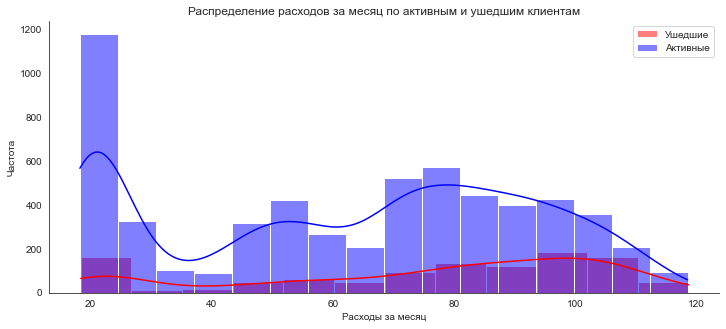

In [41]:
# построим гистограммы
sns.set_style("white")
plt.figure(figsize=(12, 5))

# распределение расходов за месяц по ушедшим клиентам
sns.histplot(data=df[df['churn'] == 1], x='monthly_charges', color='red', label='Ушедшие', kde=True)
# распределение расходов за месяц по активным клиентам
sns.histplot(data=df[df['churn'] == 0], x='monthly_charges', color='blue', label='Активные', kde=True)

# название и метки
plt.xlabel('Расходы за месяц')
plt.ylabel('Частота')
plt.title('Распределение расходов за месяц по активным и ушедшим клиентам')
# легенда
plt.legend()
sns.despine()
plt.show()

**Вывод:**
- Согласно графику, расходы за месяц у ушедших клиентов были несколько выше по сравнению с клиентами, договоры которых активны.

Оценим продолжительность пользования услугами связи по активным и ушедшим клиентам.

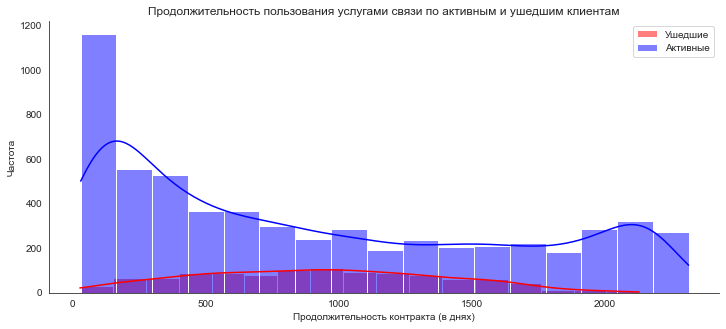

In [42]:
# построим гистограммы
sns.set_style("white")
plt.figure(figsize=(12, 5))

# продолжительность контракта по ушедшим клиентам
sns.histplot(data=df[df['churn'] == 1], x='duration', color='red', label='Ушедшие', kde=True)
# продолжительность контракта по активным клиентам
sns.histplot(data=df[df['churn'] == 0], x='duration', color='blue', label='Активные', kde=True)

# название и метки
plt.xlabel('Продолжительность контракта (в днях)')
plt.ylabel('Частота')
plt.title('Продолжительность пользования услугами связи по активным и ушедшим клиентам')
# легенда
plt.legend()
sns.despine()
plt.show()

**Вывод:**
- График распределения показывает, что активные клиенты представлены преимущественно новичками, тогда как ушедшие клиенты имеют более продолжительный опыт пользования услугами компании. 
- В частности, отток наблюдается среди абонентов, чья продолжительность контракта достигает примерно 1000 дней.

**3. Корреляционный анализ признаков**

В ходе исследовательского анализа было обнаружено, что не все признаки распределены нормально, поэтому для оценки взаимосвязи будем использовать корреляцию Phik, который устойчив к выбросам и ненормальному распределению.

In [43]:
# для дальнейшей работы нам не понадобится столбец customer_i_d
df = df.drop('customer_i_d', axis=1)

# так как мы удалили признак customer_i_d с неповторяющимися значениями, то могут возникнуть дубликаты
print('Количество дубликатов:', df.duplicated().sum())

Количество дубликатов: 4


In [44]:
# удаление дубликатов
df = df.drop_duplicates()

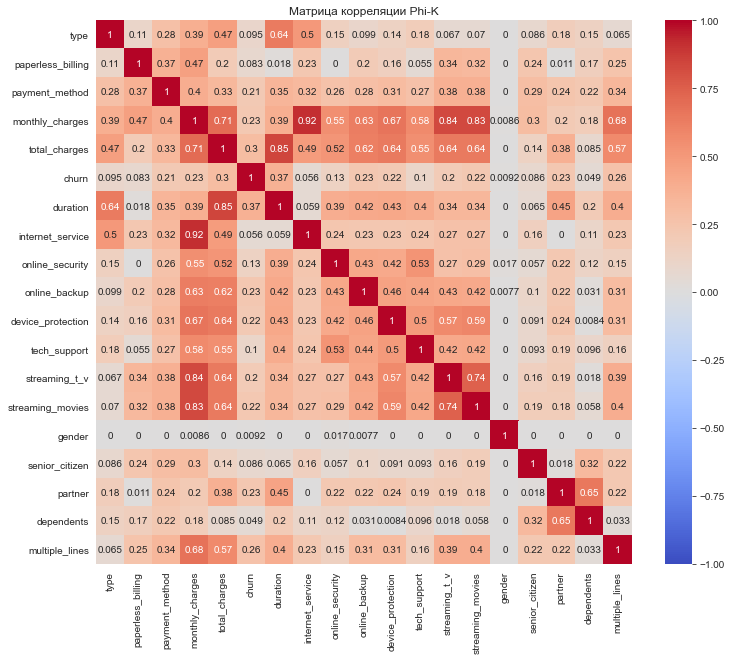

In [45]:
# укажем количественные признаки
num_cols = ['monthly_charges', 'total_charges', 'duration']

# рассчитаем матрицу корреляции Phi-K между всеми признаками
phik_matrix = df.phik_matrix(interval_cols=num_cols)

# построим heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Матрица корреляции Phi-K')
plt.show()

**Вывод:**
- Входные признаки имеют слабую связь или почти не коррелируют с таргетом `churn`.
- Входной признак `monthly_charges` тесно положительно связан с признаками `internet_service`, `streaming_t_v`, `streaming_movies`. Это довольно логично, что расходы за месяц зависят от типа подключения и опций стриминговых сервисов.
- Также вполне объяснимо `total_charges` сильно коррелирует с `duration`, так как сумма общих расходов абонента зависит от продолжительности пользования услугами компании.
- Матрица корреляции показывает, что в датасете не обнаружено пар признаков в количественной шкале, которые сильно коррелируют друг с другом, мультиколлинеарности не наблюдается.

### Обучение моделей

1. Подготовку признаков, обучение и тестировние моделей выполним в пайплайн.
2. Поскольку датасет содержит преимущественно категориальные признаки, считаем целесообразным использовать бустинговые алгоритмы, которые эффективны для решения такого рода задач:
- CatBoostClassifier()
- LGBMClassifier()
- xgb.XGBClassifier()

Для выбранных алгоритмов предварительная обработка данных с помощью `OneHotEncoder` и `StandardScaler` в большинстве случаев не требуется, так как они имеют собственные встроенные решения. Дополнительная обработка такого рода напротив может привести к увеличению использования ресурсов памяти и времени обучения.

3. Для каждой модели подберём гиперпараметры. 
4. Для оценки качества используем метрику `ROC-AUC`, так как она подходит для бинарной классификации с несбалансированной выборкой как в нашем случае. Получим метрику при помощи кросс-валидации, чтобы обеспечить статистически значимую закономерность полученных оценок.
5. Проверим качество лучшей модели на тестовой выборке.
6. Исследуем важность признаков лучшей модели.

**NB:** не смотря на то, что обычно не нужно отдельно выполнять кодирование для выбранных алгоритмов, так как эти модели способны обрабатывать категориальные функции напрямую, однако в работе с текущим датасетом нам все равно потребовалось преобразовать категориальные признаки в числовые представления поскольку возникали ошибки.

In [46]:
# объявляем константы
RANDOM_STATE = 80424
TEST_SIZE = 0.25

# делим на выборки
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('churn', axis=1),
    df['churn'],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=df['churn']
)

In [47]:
%%time
# список категориальных признаков для кодирования
ohe_columns = ['type', 'payment_method', 'internet_service', 'gender']

# пайплайн для подготовки признаков из списка ohe_columns
pipe_prep = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop='first'), ohe_columns)
    ],
    remainder='passthrough'
)

# итоговый пайплайн: подготовка данных и модели
pipe_final = Pipeline([
    ('preprocessor', pipe_prep),
    ('models', None)
])

param_grid = [
    # параметры для CatBoostClassifier
    {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE)],
        'models__learning_rate': [0.01, 0.05, 0.1],
        'models__depth': [4, 6, 8],
        'models__n_estimators': [500, 1000, 2000]
    },

    # параметры для LGBMClassifier
    {
        'models': [LGBMClassifier(random_state=RANDOM_STATE)],
        'models__learning_rate': [0.01, 0.05, 0.1],
        'models__max_depth': [4, 6, 8],
        'models__n_estimators': [500, 1000, 2000]
    },

    # параметры для xgb.XGBClassifier
    {
        'models': [xgb.XGBClassifier(seed=80424)],
        'models__learning_rate': [0.01, 0.05, 0.1],
        'models__max_depth': [4, 6, 8],
        'models__n_estimators': [500, 1000, 2000]
    }
]

# рандомизированный поиск лучшей модели и гиперпараметров
random_search = RandomizedSearchCV(
    pipe_final,
    param_distributions=param_grid,
    scoring='roc_auc',
    n_iter=10,
    cv=5,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

# опускаем предупреждения
warnings.filterwarnings('ignore')

# обучаем модель
random_search.fit(X_train, y_train)

0:	learn: 0.6273584	total: 118ms	remaining: 3m 55s
1:	learn: 0.5685351	total: 122ms	remaining: 2m 1s
2:	learn: 0.5247126	total: 126ms	remaining: 1m 24s
3:	learn: 0.4873956	total: 131ms	remaining: 1m 5s
4:	learn: 0.4645921	total: 136ms	remaining: 54.3s
5:	learn: 0.4435773	total: 140ms	remaining: 46.6s
6:	learn: 0.4229982	total: 145ms	remaining: 41.2s
7:	learn: 0.4082308	total: 149ms	remaining: 37.2s
8:	learn: 0.3934664	total: 154ms	remaining: 34s
9:	learn: 0.3864425	total: 158ms	remaining: 31.5s
10:	learn: 0.3797796	total: 163ms	remaining: 29.5s
11:	learn: 0.3717988	total: 168ms	remaining: 27.8s
12:	learn: 0.3645085	total: 173ms	remaining: 26.5s
13:	learn: 0.3598704	total: 178ms	remaining: 25.3s
14:	learn: 0.3571697	total: 184ms	remaining: 24.4s
15:	learn: 0.3543247	total: 188ms	remaining: 23.4s
16:	learn: 0.3509013	total: 195ms	remaining: 22.7s
17:	learn: 0.3476067	total: 199ms	remaining: 21.9s
18:	learn: 0.3451296	total: 204ms	remaining: 21.2s
19:	learn: 0.3425777	total: 208ms	remaini

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehot',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['type',
                                                                                'payment_method',
                                                                                'internet_service',
                                                                                'gender'])])),
                                             ('models', None)]),
                   n_jobs=-1,
                   param_distributions=[{'models': [<catboost.core.CatBoostClassifier object at 0x000001C123D5A310>],
                                         'models__d...
                                                                  n_jobs=None,
                                                                  num_parallel_tree=None,
                                                                  predictor=None,
                                                                  random_state=None,
                                                                  reg_alpha=None,
                                                                  reg_lambda=None,
                                                                  scale_pos_weight=None,
                                                                  seed=80424,
                                                                  subsample=None,
                                                                  tree_method=None,
                                                                  validate_parameters=None,
                                                                  verbosity=None)],
                                         'models__learning_rate': [0.01, 0.05,
                                                                   0.1],
                                         'models__max_depth': [4, 6, 8],
                                         'models__n_estimators': [500, 1000,
                                                                  2000]}],
                   random_state=80424, scoring='roc_auc')

In [48]:
# выведем результаты метрик пяти лучших моделей
result = pd.DataFrame(random_search.cv_results_)
with pd.option_context('max_colwidth', 3000):
    display(result[['rank_test_score', 'param_models', 'mean_test_score','params']]
            .sort_values('rank_test_score').head())

,rank_test_score,param_models,mean_test_score,params
2,1,<catboost.core.CatBoostClassifier object at 0x000001C123D5A310>,0.916088,"{'models__n_estimators': 2000, 'models__learning_rate': 0.1, 'models__depth': 4, 'models': <catboost.core.CatBoostClassifier object at 0x000001C123D5A310>}"
5,2,<catboost.core.CatBoostClassifier object at 0x000001C123D5A310>,0.906845,"{'models__n_estimators': 500, 'models__learning_rate': 0.1, 'models__depth': 4, 'models': <catboost.core.CatBoostClassifier object at 0x000001C123D5A310>}"
6,3,<catboost.core.CatBoostClassifier object at 0x000001C123D5A310>,0.901594,"{'models__n_estimators': 2000, 'models__learning_rate': 0.1, 'models__depth': 6, 'models': <catboost.core.CatBoostClassifier object at 0x000001C123D5A310>}"
9,4,"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None,\n enable_categorical=False, gamma=None, gpu_id=None,\n importance_type=None, interaction_constraints=None,\n learning_rate=None, max_delta_step=None, max_depth=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=100, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=None, reg_alpha=None,\n reg_lambda=None, scale_pos_weight=None, seed=80424,\n subsample=None, tree_method=None, validate_parameters=None,\n verbosity=None)",0.900072,"{'models__n_estimators': 1000, 'models__max_depth': 4, 'models__learning_rate': 0.05, 'models': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, enable_categorical=False, gamma=None, gpu_id=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_delta_step=None, max_depth=None, min_child_weight=None, missing=nan, monotone_constraints=None, n_estimators=100, n_jobs=None, num_parallel_tree=None, predictor=None, random_state=None, reg_alpha=None, reg_lambda=None, scale_pos_weight=None, seed=80424, subsample=None, tree_method=None, validate_parameters=None, verbosity=None)}"
7,5,LGBMClassifier(random_state=80424),0.891494,"{'models__n_estimators': 2000, 'models__max_depth': 4, 'models__learning_rate': 0.05, 'models': LGBMClassifier(random_state=80424)}"


In [49]:
# рассмотрим модели с лучшими параметрами: время обучения, время прогноза и качество прогноза
result['model'] = result['param_models'].apply(lambda x: str(x).split('(')[0])
result['mean_test_score'] = -result['mean_test_score']
result[result['mean_test_score'].isin(result.groupby('model')['mean_test_score'].min())][['model', 'mean_test_score', 'mean_fit_time', 'mean_score_time']]

,model,mean_test_score,mean_fit_time,mean_score_time
2,<catboost.core.CatBoostClassifier object at 0x...,-0.916088,9.297678,0.030826
7,LGBMClassifier,-0.891494,21.402958,0.071131
9,XGBClassifier,-0.900072,8.837664,0.031120


**Вывод:**
- Из трёх моделей наиболее эффективной с точки зрения метрики качества и скорости обучения оказалась `CatBoostClassifier`с гиперпараметрами `n_estimators=2000`, `learning_rate=0.1`, `depth=4`.
- Значение метрики ROC AUC лучшей модели на **обучающей** выборке составляет *0.92*, что позволяет говорить о хорошей способности модели различать положительные и отрицательные экземпляры.
- Протестируем лучшую модель на тестовой выборке и рассмотрим матрицу ошибок.

In [50]:
# оценим работу модели на тестовой выборке и рассчитаем прогноз
y_test_prob = random_search.best_estimator_.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_prob)}')

Метрика ROC-AUC на тестовой выборке: 0.9298736351367931


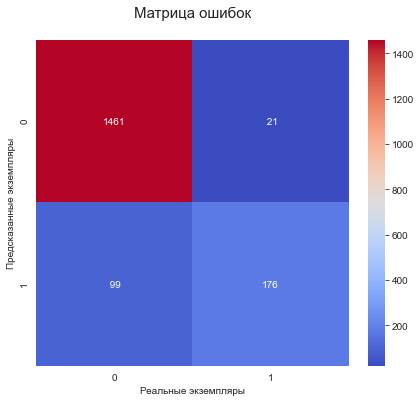

In [51]:
# рассмотрим подробные показатели классификации
y_pred = random_search.best_estimator_.predict(X_test)
# сформируем confusion matrix
plt.figure(figsize=(7, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='3.0f', cmap= 'coolwarm')
plt.title('Матрица ошибок', y=1.05, size=15)
plt.xlabel('Реальные экземпляры')
plt.ylabel('Предсказанные экземпляры')
plt.show()

**Вывод:**
- Модель показывает довольно высокие прогнозные способности на **тестовых** данных. Оценка вероятности для положительного класса составляет *0.93*, это значит, что обобщающие способности модели устойчивы и на незнакомых данных.
- Согласно матрице ошибок, в **(TN):1461** случае модель правильно идентифицировала клиентов, которые не уходят; в **(FN):99** случаях модель ошибочно предсказала клиентов как не уходящие, хотя на самом деле они ушли; в **(FP):21** случае модель ошиблась, предсказав отток клиентов, хотя фактический это не так; в **(TP):176** случаях модель идентифицировала клиентов как находящихся в группе риска и они действительно отказались от услуги.
- Рассмотрим значимость признаков, чтобы оценнить их вклад в прогнозы модели.

### Анализ важности признаков

1. Оценим важность признаков для лучшей модели и построим график важности с помощью метода SHAP.
2. Сделаем выводы о значимости признаков.

100%|===================| 1752/1757 [01:06<00:00]        

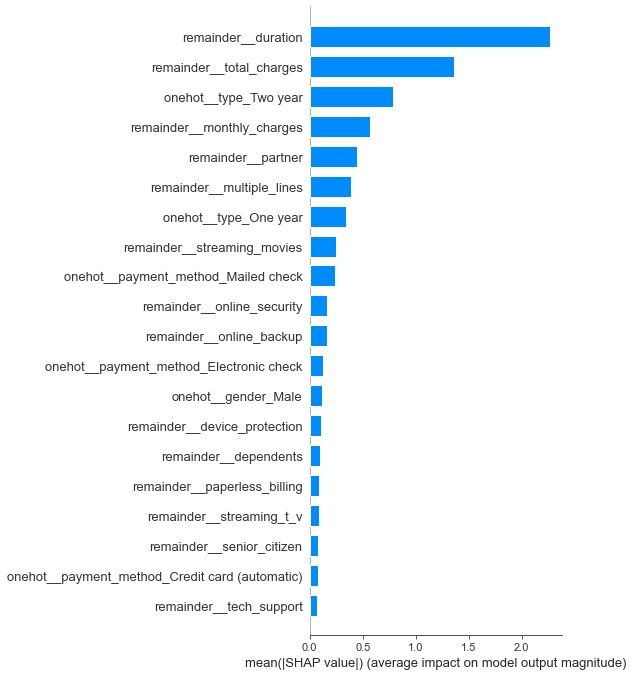

In [52]:
# извлечение лучшей модели и повторное обучение на тренировочных данных
final_model = random_search.best_estimator_.named_steps['models']
# обработка train данных для лучшей модели
X_train_shap = random_search.best_estimator_.named_steps['preprocessor'].fit_transform(X_train)
# обработка test данных для лучшей модели
X_test_shap = random_search.best_estimator_.named_steps['preprocessor'].transform(X_test)
# получение названий признаков после обработки
feature_names = random_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
# вычисление SHAP значений на тестовых данных
explainer = shap.Explainer(final_model, X_train_shap)
shap_values = explainer.shap_values(X_test_shap)
# визуализация SHAP значений
shap.summary_plot(shap_values, X_test_shap, plot_type="bar", feature_names=feature_names)

**Вывод:**
- Признаки на графике расположены в порядке убывания их вклада. В числе признаков лидеров: продолжительность контракта, общие расходы абонента, тип оплаты раз в два года и расходы за месяц.
- Модель позволила наметить различие между двумя классами клиентов: те, кто находятся в группе риска расторжения договора или — нет. Указанные признаки влияют на решения модели, а значит, и клиенты с высокими значениями этих признаков ведут себя по-разному.
- Предложения промокодов и специальных условий пользователям отнесенным в группу риска может быть оправданной мерой для удержания клиентов.

### Итоговый отчёт

На данных компании оператора связи был проведён исследовательский анализ с последующей разработкой решения на основе моделирования, которое позволит персонализировать пользовательские предложения для предупреждения отказа клиентов от услуг связи.

Учитывая бизнес-задачи заказчика, предстояло разработать прогнозную модель и обучить её классифицировать клиентов по критерию откажется / не откажется пользователь от услуг связи (задача бинарной классификации).

Работа включала предварительный этап и предобработку данных, исследовательский анализ, обучение разных моделей с подбором гиперпараметров, анализ моделей и проверку на тестовой выборке.

На **предварительном этапе** и **этапе предобработки** данных мы изучили основные сведения о четырёх датасетах, определили количество и тип данных в таблицах, проверили на наличие пропусков и дубликатов, сформировали целевую переменную, а также создали новый входной признак, используя столбцы с датами начала и окончания договора. Это позволило с одной стороны избежать утечки данных при обучении модели, так как столбцы с датами были исключены из итогового датафрейма, с другой — обеспечить модели возможность выучить соответствующие закономерности для более точного прогноза. Пропуски, возникшие в результате объединения четырёх датафреймов, были заполнены значением соответствующим логике набора данных.

На этапе **исследовательского анализа** были построены графики для оценки характера распределения данных, проведён корреляционный анализ всех признаков для изучения типов взаимосвязи.

Этап **разработки модели** включал подготовку данных обучающего и тестового наборов, выбор алгоритмов моделирования, настройку гиперпараметров, обучение модели, оценку её качества с использованием метрики *ROC-AUC* и получение прогноза. Метрика была получена при помощи кросс-валидации, чтобы обеспечить статистически значимую закономерность оценок.

На этапе **анализа моделей** проводилось сопоставление результатов с учётом гиперпараметров, оценок метрики качества и скорости обучения.

Поскольку датасет содержит преимущественно категориальные признаки, в контексте поставленной задачи мы рассмотрели возможности бустинговых алгоритмов, которые эффективны для решения такого рода задач. В частности: 
- CatBoostClassifier
- LGBMClassifier
- xgb.XGBClassifier

Этап **оценки важности признаков** для лучшей модели предполагал изучение признаков с помощью метода *SHAP*, которые вносят наибольший вклад в корректное предсказание модели.

**Основные результаты и выводы:**
- Из трёх моделей наиболее эффективной с точки зрения метрики качества и скорости обучения оказалась `CatBoostClassifier`с гиперпараметрами `n_estimators=2000`, `learning_rate=0.1`, `depth=4`.
- Значение метрики ROC AUC лучшей модели на **обучающей** выборке составляет *0.92*, на **тестовых** данных *0.93*, что позволяет говорить о хорошей способности модели различать положительные и отрицательные экземпляры.
- Согласно матрице ошибок, в **(TN):1461** случае модель правильно идентифицировала клиентов, которые не уходят; в **(FN):99** случаях модель ошибочно предсказала клиентов как не уходящие, хотя на самом деле они ушли; в **(FP):21** случае модель ошиблась, предсказав отток клиентов, хотя фактический это не так; в **(TP):176** случаях модель идентифицировала клиентов как находящихся в группе риска и они действительно отказались от услуги. В контексте поставленной задачи именно этот показатель требует особого внимания, так как нам важно сосредоточиться на максимизации количества истинных положительных результатов и минимизации количества ложных отрицательных результатов. Это гарантирует, что модель эффективно выявляет клиентов, подверженных риску оттока, и позволяет бизнесу принимать соответствующие меры для их удержания.
- В нашем случае, модель позволила наметить различие между двумя классами клиентов: теми, кто находятся в группе риска `отток` и теми, кто не попал в таковую, то есть `не отток`. 
- Оценка важности признаков с помощью метода SHAP показала, что в числе признаков лидеров: `продолжительность контракта`, `общие расходы абонента`, `тип оплаты раз в два года` и `расходы за месяц`. Указанные признаки влияют на решения модели, а значит, и клиенты с высокими значениями этих признаков ведут себя по-разному.
- Предложения промокодов и специальных условий пользователям отнесенным в группу риска может быть оправданной мерой для удержания клиентов.

**Рефлексия:**

В целом проект показался довольно занимательным и полезным с точки зрения прикладного характера. Непреодолимых трудностей в процессе выполнения работы не возникало. Я связываю это с тем, что на протяжении курса мы научились справляться с похожими задачами, соответственно, в данном проекте нужно было синтезировать полученный опыт. 

При этом, на этапе моделирования я всё же попала в интеллектуальную раскоряку, так как выбранные алгоритмы не оправдали моих ожиданий в плане обработки признаков. В частности, во многих источниках говорится, что для выбранных алгоритмов предварительная обработка данных с помощью кодировщиков в большинстве случаев не требуется, так как они имеют собственные встроенные решения. Более того, дополнительная обработка такого рода, напротив, может даже привести к увеличению использования ресурсов памяти и времени обучения. Однако, на практике это оказалось не так, и в работе с текущим датасетом мне всё равно потребовалось преобразовать категориальные признаки в числовые представления поскольку возникали ошибки, которые напрямую указывали "иди преобразуй свой бешельмепельме".

Я экспериментировала с CatBoost и, справедливости ради, он действительно проглатывает напрямую переданные в аргументах категориальные переменные, но скорость при этом существенно падает. Поэтому, было принято решение отдельно кодировать категориальные признаки в пайплайн, чтобы унифицировать стартовые условия для всех трёх моделей.